Rows: 85 Columns: 13── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): competitorname
dbl (12): chocolate, fruity, caramel, peanutyalmondy, nougat, crispedricewaf...
ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

[1] "Correlation Table"


`geom_smooth()` using formula 'y ~ x'


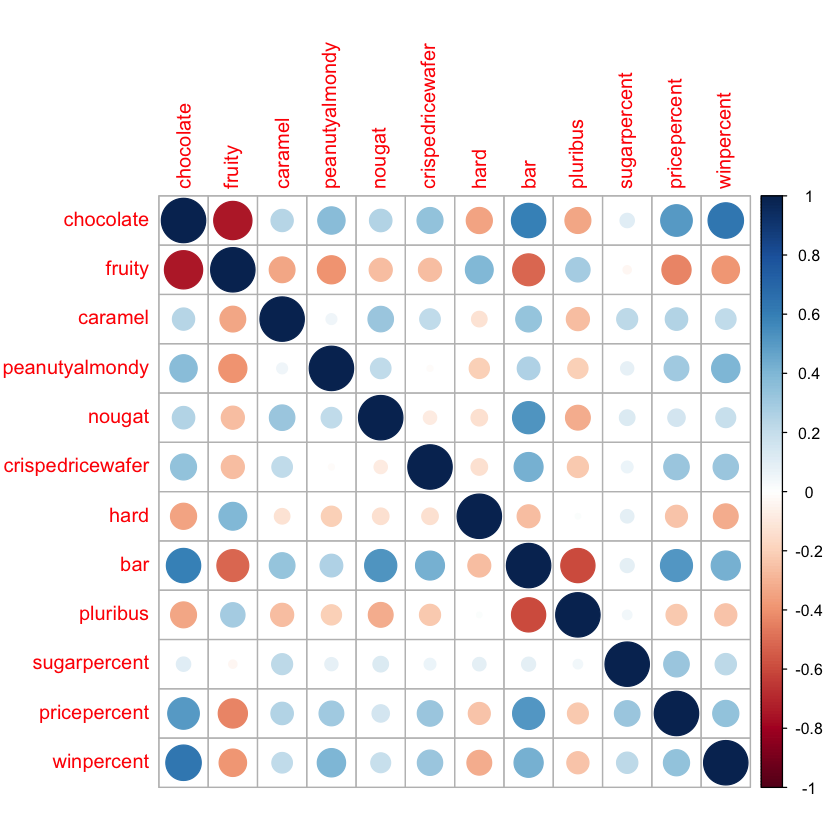

term,estimate,std.error,statistic,p.value
(Intercept),0.03145309,1.423443,-2.430204,0.015090318
chocolate,30.19775552,1.298719,2.623946,0.008691762
sugarpercent,13.98404330,1.288364,2.047494,0.040609652
fruity,5.59537106,1.327963,1.296677,0.194742357
hard,0.05343994,1.445249,-2.026776,0.042685323


[1] "ROC_AUC"


.metric,.estimator,.estimate
roc_auc,binary,0.1583333


[1] "ROC Curve"


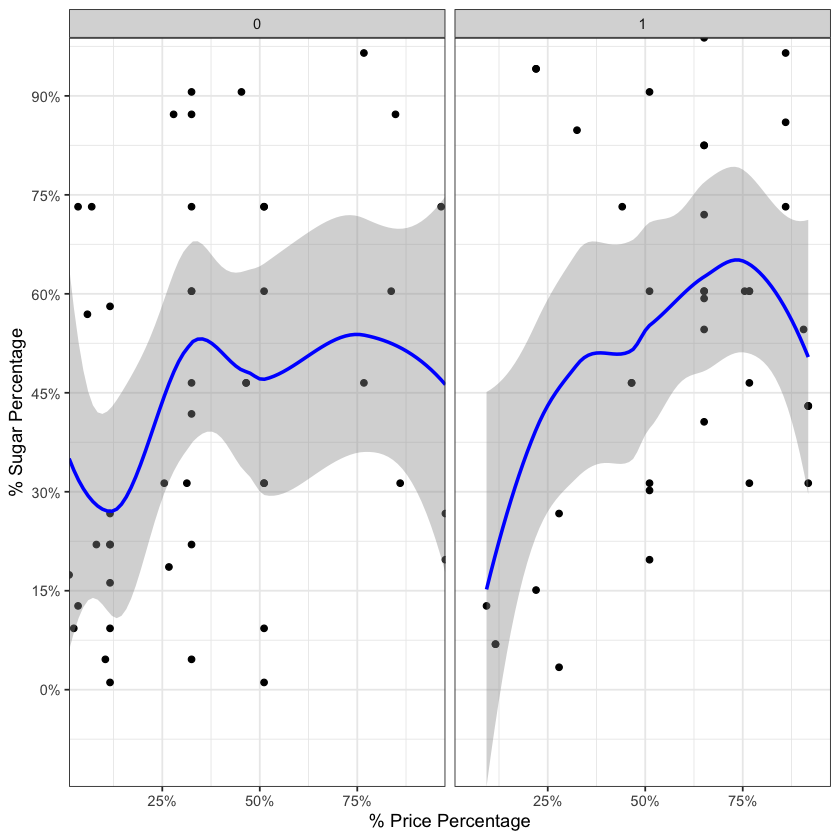

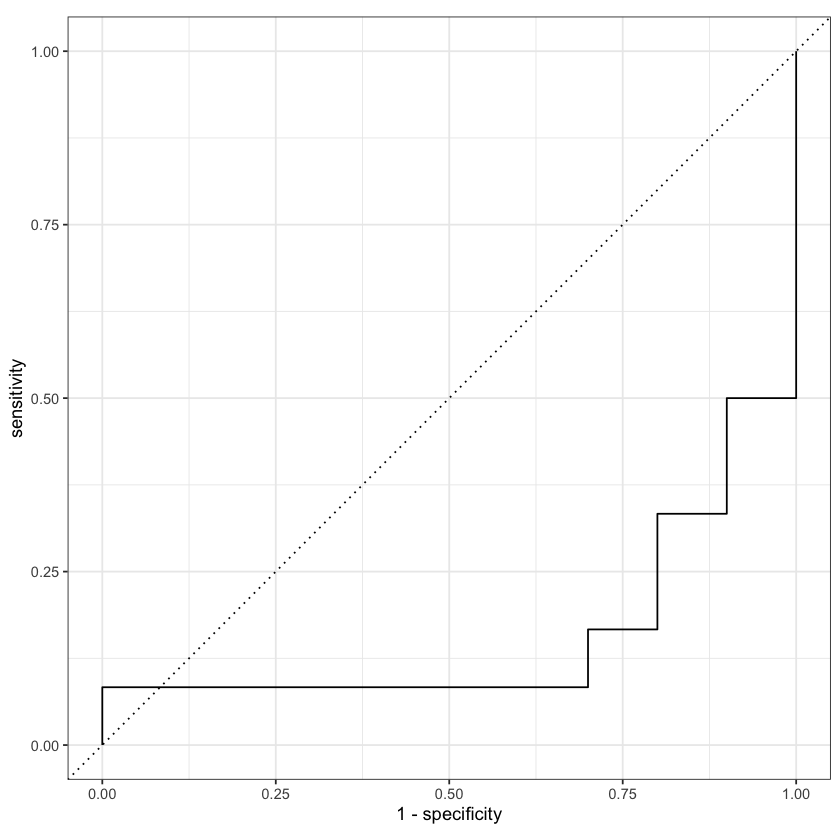

In [46]:
#install.packages("corrplot")
#library(dplyr)
#update.packages()
#https://medium.com/the-researchers-guide/modelling-binary-logistic-regression-using-tidymodels-library-in-r-part-1-c1bdce0ac055

library(ggplot2)
library(dplyr)
library(tidyr)
library(tidyverse)
library(tidymodels)
library(corrplot)
library(readr)
#install.packages("plotly")
#library(plotly)


### Loading candy data from GitHub repository

urlfile2 = "https://raw.githubusercontent.com/ANiraula/data_projects/main/candy-data.csv"
    candy <- read_csv(url(urlfile2), col_names = TRUE, na = c(""), col_types = NULL)


#plot Correlation table
#candy <- data.frame(candy)
print("Correlation Table")
cor(candy[, 2:13]) %>%
corrplot()

### Creating binary variables w/ 1 if candy wins >= 50% of the time
candy$win <- ifelse(candy$winpercent > 50, 1, 0)

### Visualize simple regression of sugarpercent & pricepercent (by 1/0 win category)
### See that candies in a win group-that are higehr priced- have sugarperecnt spike at 60% vs. 50% for non-win candies
plot <- ggplot(data = candy, aes(x = pricepercent, y = sugarpercent)) + 
             geom_point() +
             facet_wrap(~win)+
             geom_smooth(method = 'loess', color = "blue",span = 0.8)+
             theme_bw()+
             scale_y_continuous(breaks = seq(0, 1, by = 0.15),labels = function(x) paste0(x*100, "%"), 
             name = "% Sugar Percentage", expand = c(0,0)) +
             scale_x_continuous(breaks = seq(0, 1, by = 0.25),labels = function(x) paste0(x*100, "%"), 
             name = "% Price Percentage", expand = c(0,0)) 

plot


##############
###### Creating Test & Train data splits ######

candy <- candy %>% select(-competitorname)
candy$win <- as.factor(candy$win)

###### Split ######
candy_split <- initial_split(candy,
                             prop = 0.75,
                             strata = win)

###### Train ######
candy_train <- candy_split %>%
  training()

###### Test ######
candy_test <- candy_split %>%
  testing()

### Number of rows in train and test dataset
#nrow(candy_train)
#nrow(candy_test)


##### Logistic model
#####
fitted_logistic_model<- logistic_reg() %>%
  # Set the engine
  set_engine("glm") %>%
  # Set the mode
  set_mode("classification") %>%
  # Fit the model
  fit(win ~ chocolate + sugarpercent+fruity+hard, data = candy_train)

# Generate Summary Table
#tidy(fitted_logistic_model)

# Exponentiate to get ODDS
tidy(fitted_logistic_model, exponentiate = TRUE)

###
# Class prediction
pred_class <- predict(fitted_logistic_model,
                      new_data = candy_test,
                      type = "class")

# Prediction Probabilities
pred_proba <- predict(fitted_logistic_model,
                      new_data = candy_test,
                      type = "prob")

## Results
candy_results <- candy_test %>%
  select(win) %>%
  bind_cols(pred_class, pred_proba)

## ROC_AUC
print("ROC_AUC")
roc_auc(candy_results,
        truth = win,
        .pred_1)

###
print("ROC Curve")
candy_results %>%
  roc_curve(truth = win, .pred_1) %>%
  autoplot()
